In [65]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
import optax

np.random.seed(42)

key = jax.random.PRNGKey(42)

In [18]:
degree = 5
scaling = 1
coeffs = [0.05 + 0.05j] * degree
c0 = 0.0

def target_function(x):
    res = c0
    for idx, c in enumerate(coeffs):
        exponent = scaling * (idx + 1) * x * 1j
        conj_c = jnp.conjugate(c)
        res += c * jnp.exp(exponent) + conj_c * jnp.exp(-exponent)
    return jnp.real(res)

def minmax_scaler(y):
    # Scale y to [0, 1]
    y_min = jnp.min(y)
    y_max = jnp.max(y)
    y_scaled = (y - y_min) / (y_max - y_min)
    return y_scaled

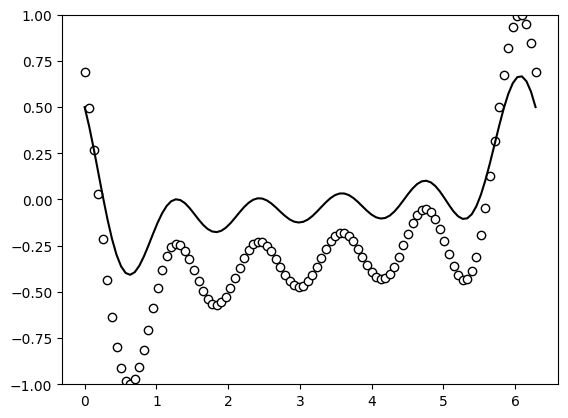

In [19]:
x_raw = jnp.linspace(-12, 12, 100)
x = minmax_scaler(x_raw) * 2 * jnp.pi
target_y = jax.vmap(target_function)(x)

target_y_scaled = minmax_scaler(target_y) * 2 - 1

plt.plot(x, target_y, c="black")
plt.scatter(x, target_y_scaled, facecolor="white", edgecolor="black")
plt.ylim(-1, 1)
plt.show()

In [59]:
scaling = 1

dev = qml.device("default.qubit", wires=1)

def S(x):
    """Data-encoding circuit block"""
    qml.RX(scaling * x, wires=0)

def W(theta):
    """Trainable circuit block"""
    qml.Rot(theta[0], theta[1], theta[2], wires=0)

@qml.qnode(dev)
def serial_quantum_model(weights, x):

    for theta in weights[:-1]:
        W(theta)
        S(x)

    # (L+1)'th unitary
    W(weights[-1])

    return qml.expval(qml.PauliZ(wires=0))

jit_model = jax.jit(serial_quantum_model)

0: ──Rot(3.70,4.34,5.47)──RX(M0)──Rot(2.46,5.15,5.83)──RX(M0)──Rot(1.25,5.89,2.39)──RX(M0) ···

0: ··· ──Rot(2.70,2.89,4.70)──RX(M0)──Rot(1.11,5.26,6.21)──RX(M0)──Rot(1.94,3.74,3.31)─┤  <Z>

M0 = 
[0.         0.06346646 0.12693317 0.19039938 0.25386608 0.31733254
 0.38079923 0.44426572 0.50773215 0.57119864 0.6346651  0.6981318
 0.7615983  0.8250648  0.88853145 0.95199764 1.0154643  1.0789309
 1.1423974  1.205864   1.2693305  1.3327968  1.3962634  1.45973
 1.5231966  1.5866629  1.6501297  1.7135961  1.7770627  1.8405291
 1.9039956  1.9674623  2.0309286  2.0943952  2.1578617  2.2213285
 2.2847948  2.348261   2.4117277  2.4751945  2.538661   2.6021273
 2.6655936  2.7290604  2.7925267  2.8559935  2.91946    2.9829266
 3.0463932  3.1098595  3.1733258  3.2367923  3.300259   3.3637257
 3.4271922  3.4906588  3.5541253  3.6175916  3.6810582  3.7445247
 3.807991   3.8714578  3.9349246  3.9983912  4.061857   4.125324
 4.1887903  4.252257   4.3157234  4.37919    4.442657   4.506123
 4.5695896  4.

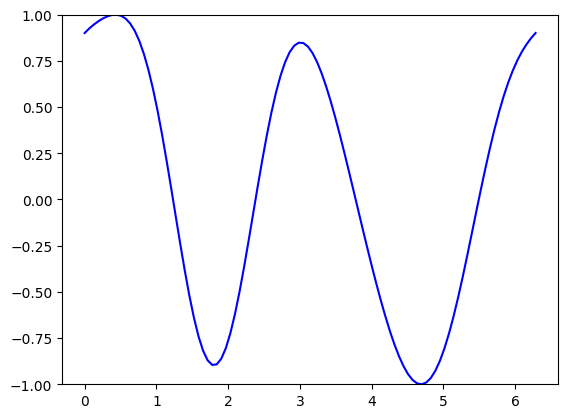

In [61]:
r = 5   # number of times encoding gets repeated (= L)
key, subkey = jax.random.split(key)
weights = 2 * jnp.pi * jax.random.uniform(subkey, shape=(r+1, 3))    # some random initial weights

weights_np = 2 * np.pi * np.random.random(size=(r + 1, 3), requires_grad=True)
x_np = np.linspace(-6, 6, 70, requires_grad=True)

print(qml.draw(serial_quantum_model, level="device")(weights, x))

random_quantum_model_y = jax.vmap(lambda x_: jit_model(weights, x_))(x)
random_quantum_model_y_scaled = minmax_scaler(random_quantum_model_y) * 2 - 1

plt.plot(x, random_quantum_model_y_scaled, c="blue")
plt.ylim(-1,1)
plt.show()

In [48]:
def square_loss(targets, predictions):
    return 0.5 * jnp.mean((targets - predictions) ** 2)

def cost (weights, x, y):
    predictions = jax.vmap(lambda x_: jit_model(weights, x_))(x)
    # preds = jit_model(weights, x)
    return square_loss(y, predictions)

max_steps = 1000
opt = optax.adam(0.3)
opt_state = opt.init(weights)

@jax.jit
def update_step(weights, opt_state, x_batch, y_batch):
    loss, grads = jax.value_and_grad(cost)(weights, x_batch, y_batch)
    updates, opt_state = opt.update(grads, opt_state)
    weights = optax.apply_updates(weights, updates)
    return weights, opt_state, loss

batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):
    key, subkey = jax.random.split(key)

    batch_index = jax.random.choice(subkey, len(x), (batch_size,), replace=False)
    x_batch = x[batch_index]
    y_batch = target_y_scaled[batch_index]

    weights, opt_state, _ = update_step(weights, opt_state, x_batch, y_batch)

    c = cost(weights, x, target_y_scaled)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.06885446608066559
Cost at step  20: 0.037045639008283615
Cost at step  30: 0.019479967653751373
Cost at step  40: 0.0068397680297493935
Cost at step  50: 0.005488378927111626
Cost at step  60: 0.00750449113547802
Cost at step  70: 0.005857536103576422
Cost at step  80: 0.006774110719561577
Cost at step  90: 0.012946436181664467
Cost at step 100: 0.015914779156446457
Cost at step 110: 0.02051025815308094
Cost at step 120: 0.040747735649347305
Cost at step 130: 0.017503822222352028
Cost at step 140: 0.004747550934553146
Cost at step 150: 0.01756751909852028
Cost at step 160: 0.028940143063664436
Cost at step 170: 0.008081737905740738
Cost at step 180: 0.006227449048310518
Cost at step 190: 0.004648896399885416
Cost at step 200: 0.0022772429510951042
Cost at step 210: 0.001071058213710785
Cost at step 220: 0.002504989504814148
Cost at step 230: 0.0008043558918870986
Cost at step 240: 0.0008862402755767107
Cost at step 250: 0.0020595532841980457
Cost at step 260: 0.0029

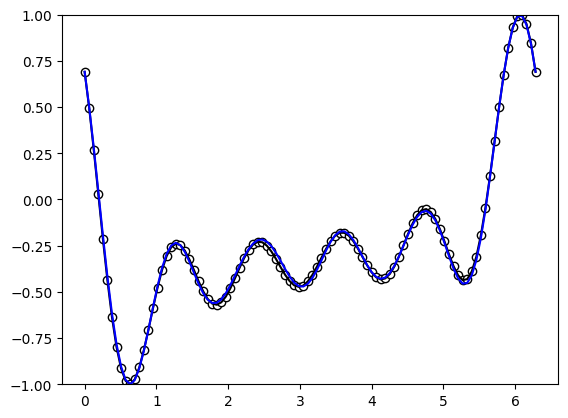

In [49]:
predictions = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, target_y_scaled, c="black")
plt.scatter(x, target_y_scaled, facecolor="white", edgecolor="black")
plt.plot(x, predictions, c="blue")
plt.ylim(-1,1)
plt.show()

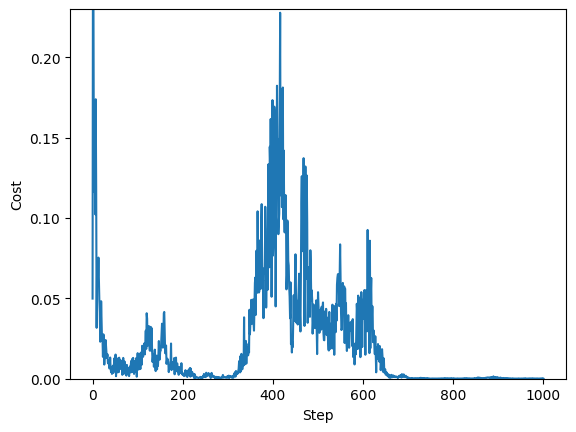

In [50]:
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.ylim(0, 0.23)
plt.show()

In [66]:
qfim = [qml.gradients.quantum_fisher(serial_quantum_model)(weights_np, x_) for x_ in x_np]
qfim

[tensor([[[[ 0.00000000e+00,  0.00000000e+00,  1.11022302e-16],
           [-3.46944695e-17,  1.11022302e-16,  0.00000000e+00],
           [ 1.11022302e-16, -2.22044605e-16, -2.22044605e-16],
           [ 1.11022302e-16,  6.66133815e-16,  4.71844785e-16],
           [-5.55111512e-17, -1.11022302e-16, -2.49800181e-16],
           [-4.44089210e-16, -7.77156117e-16,  1.11022302e-16]],
 
          [[ 0.00000000e+00,  1.00000000e+00, -5.55111512e-17],
           [ 2.64061863e-02, -2.34072941e-01,  9.45376380e-01],
           [ 9.02602365e-01,  4.30431891e-01, -6.82967993e-01],
           [-6.89027997e-01, -2.60360491e-01, -5.42799625e-01],
           [-2.86597568e-01, -8.78314887e-01,  1.48011254e-01],
           [ 3.26580862e-01, -8.26929627e-01, -2.53770589e-01]],
 
          [[ 1.11022302e-16, -5.55111512e-17,  9.33621531e-01],
           [ 9.65682728e-01, -1.41328345e-02, -2.28765530e-01],
           [-4.47859728e-02,  1.07535282e-01, -5.88128425e-01],
           [-6.86922568e-01,  5.94

In [76]:
qfim_mean = np.mean(qfim, axis=0)
qfim_mean

tensor([[[[ 0.00000000e+00,  0.00000000e+00,  1.11022302e-16],
          [-1.01218017e-17, -1.93545576e-17,  3.05559149e-17],
          [ 7.65260871e-17, -2.28859590e-17,  7.53365624e-18],
          [ 3.17206578e-18,  3.82134800e-17,  1.90571765e-17],
          [ 1.51168760e-17,  1.10031032e-17, -1.51912213e-17],
          [-6.13596475e-17, -3.40873163e-17,  2.48870864e-17]],

         [[ 0.00000000e+00,  1.00000000e+00, -5.55111512e-17],
          [-1.18952467e-17, -3.22868454e-01,  9.21349068e-01],
          [ 1.71357725e-02,  2.46630219e-01, -1.87714088e-01],
          [-4.93217902e-01, -7.25506349e-02, -5.04631797e-01],
          [ 3.50009176e-01, -3.79214152e-01, -3.56399005e-01],
          [ 4.61335538e-01, -1.25783918e-01, -4.33002948e-01]],

         [[ 1.11022302e-16, -5.55111512e-17,  9.33621531e-01],
          [-2.99426410e-02,  3.58131443e-05, -1.81014938e-02],
          [-3.27284266e-01, -3.84079212e-01, -2.15837714e-02],
          [-4.26250579e-01,  2.27361981e-01, -5.376